In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import PCA

rng = np.random.default_rng(42)

In [24]:
def build_graph(pts, M, batch):
    n, d = pts.shape
    delta = n ** (-1.0 / d)
    # cos_thr = np.cos(np.arcsin(min(1 - 1e-6, M * delta)))
    # cos_thr = np.cos(np.arcsin(M * delta))
    cos_thr2 = 1 - (M * delta)**2

    G = [[] for _ in range(n)]
    for start in range(0, n, batch):
        end = min(start + batch, n)
        block = pts[start:end]
        dots = block @ pts.T
        for local_idx in range(end - start):
            i = start + local_idx
            idx = np.where((dots[local_idx] > 0) & (dots[local_idx]**2 >= cos_thr2))[0]
            idx = idx[idx != i]
            G[i] = idx.tolist()
    return G

In [25]:
def getPts(n, d):
    pts = rng.normal(size=(n, d+1))
    pts /= np.linalg.norm(pts, axis=1, keepdims=True)
    return pts

In [26]:
def greedySearch(pts, n, d, M, n_query, S, norm_plot=True):
    lmbs = np.linspace(0, 1, 100)

    G = build_graph(pts, M, batch=5000)
    print("Average degree:", np.mean([len(lst) for lst in G]))


    # Run greedy search per deletion rate
    suc = []
    for lmb in lmbs:
        keep = rng.random(n) >= lmb
        if not np.any(keep):
            suc.append(0)
            continue
        idmap = -np.ones(n, int)
        idmap[keep] = np.arange(np.sum(keep))
        pts_k = pts[keep]
        Gk = [[idmap[j] for j in G[i] if keep[j]] for i in np.where(keep)[0]]

        good = 0
        for _ in range(n_query):
            q = rng.normal(size=d+1)
            q /= np.linalg.norm(q)
            true = np.argmin(np.linalg.norm(pts_k - q, axis=1))
            cur = np.random.randint(len(pts_k))
            # choose rho(x, q) < pi/2, not robust for very small datasets, just implemented as paper's descrption
            while np.dot(pts_k[cur], q) <= 0:
                cur = np.random.randint(len(pts_k))
            best = np.linalg.norm(pts_k[cur] - q)
            while Gk[cur]:
                dists = np.linalg.norm(pts_k[Gk[cur]] - q, axis=1)
                idx = np.argmin(dists)
                if dists[idx] < best:
                    best = dists[idx]
                    cur = Gk[cur][idx]
                else:
                    break
            good += (cur == true)
        rate = good / n_query
        # print(f"ρ = {lmd:.2f}, success = {rate:.2f}")
        suc.append(rate)

    if norm_plot:
        suc_thry = 1-np.power(np.e, 0.7*np.log(n)/(d)-((1-lmbs)**2)*(S**d))
        suc_thry = (suc_thry - suc_thry[-1]) / (suc_thry[0] - suc_thry[-1])
        plt.plot(lmbs, suc_thry, marker='o', label = 'theory')
        plt.plot(lmbs, suc/suc[0], marker='o', label = 'expt.')
        plt.ylabel("Success rate (w. del / w.o. del) ")
        plt.legend()
    else:
        plt.plot(lmbs, suc, marker='o')
        plt.ylabel("Success rate")
    plt.xlabel(f"Deletion fraction $\\lambda$")
    plt.title("Greedy walk success (M = "+str(M)+", d = "+str(d)+", n = "+str(n)+")")
    plt.grid()
    plt.ylim(0, 1.05)
    plt.show()

Average degree: 56.92964


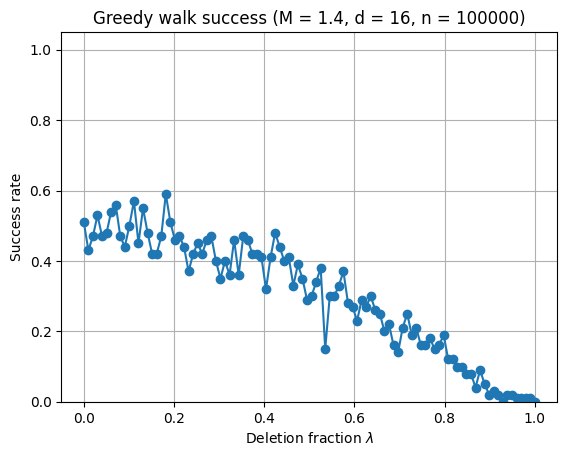

In [174]:
n, d, M, S = 100000, 16, 1.4, 1.1
n_query = 100
pts = getPts(n, d)
greedySearch(pts, n, d, M, n_query, S, False)

Average degree: 56.8908


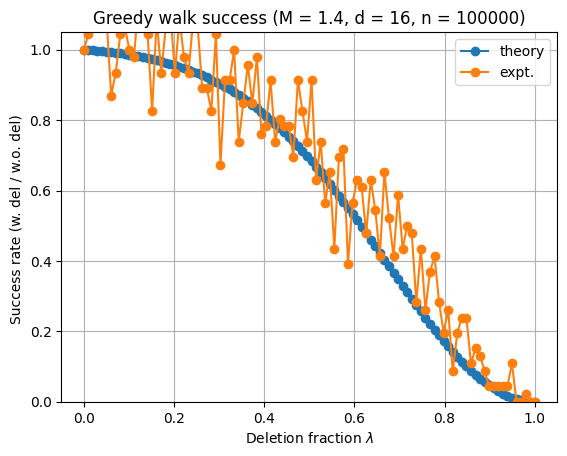

In [27]:
n, d, M, S = 100000, 16, 1.4, 1.1
n_query = 100
pts = getPts(n, d)
greedySearch(pts, n, d, M, n_query, S)

Average degree: 3130.948


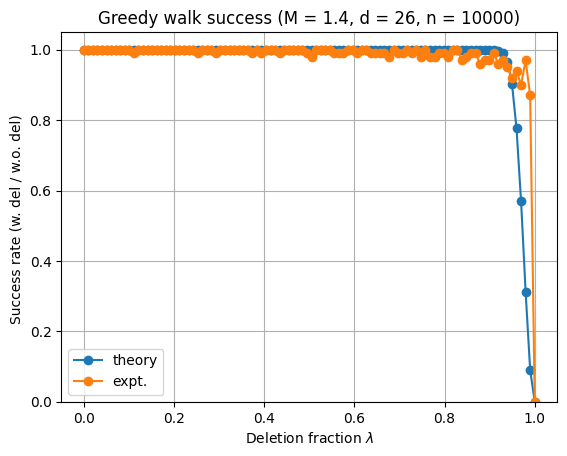

In [28]:
n, d, M, S = 10000, 26, 1.4, 1.3
n_query = 100
pts = getPts(n, d)
greedySearch(pts, n, d, M, n_query, S)

In [128]:
def greedyPath(pts, G, query, true):
    cur = np.random.randint(len(pts))
    # choose rho(x, q) < pi/2, not robust for very small datasets, just implemented as paper's descrption
    while np.dot(pts[cur], query) <= 0:
        cur = np.random.randint(len(pts))
    path = [cur]
    best = np.linalg.norm(pts[cur] - query)
    n_neighbor = len(G[cur])
    while True:
        dists = np.linalg.norm(pts[G[cur]] - query, axis=1)
        # dists = cosine_distances(pts[G[cur]], query.reshape(1, -1)).flatten()
        idx = np.argmin(dists)
        if dists[idx] < best:
            best = dists[idx]
            cur = G[cur][idx]
            path.append(cur)
            n_neighbor += len(G[cur])
        else:
            n_neighbor /= len(path)
            approx = best / np.linalg.norm(pts[true] - query)
            print("Opt. :",true,"find :", cur, '#steps :', len(path)-1, '#neighbors(avg) :', int(n_neighbor), 'approx :', approx)
            break
    return path

In [129]:
def run_walk_plot(pts, n, d, lmbs, M):
    G = build_graph(pts, M, batch=5000)
    
    query = rng.normal(size=d+1)
    query /= np.linalg.norm(query)

    pca = PCA(n_components=2)
    Xq_2d = pca.fit_transform(np.vstack((pts,query)))
    X_2d, q_2d = Xq_2d[:n,:], Xq_2d[-1,:]

    fig, axs = plt.subplots(2, 3, figsize=(8, 6), sharex=True, sharey=True)
    axs = axs.flatten()
    
    for i, lmb in enumerate(lmbs):
        keep = rng.random(n) >= lmb
        if not np.any(keep):
            continue
        idmap = np.full(n, -1)
        idmap[keep] = np.arange(np.sum(keep))
        pts_k = pts[keep]
        Gk = [[idmap[j] for j in G[i] if keep[j]] for i in np.where(keep)[0]]

        true = np.argmin(np.linalg.norm(pts_k - query, axis=1))
        path = greedyPath(pts_k, Gk, query, true)
        X_proj = X_2d[keep]
        walk_2d = X_proj[path]

        ax = axs[i]
        ax.scatter(X_proj[:, 0], X_proj[:, 1], alpha=0.01, s=10)
        ax.scatter(q_2d[0], q_2d[1], color = 'green', s=100, label = 'query')       # query
        ax.scatter(X_proj[true, 0], X_proj[true, 1], color = 'cyan', s=70, label = 'opt.')       # opt
        ax.plot(walk_2d[:, 0], walk_2d[:, 1], '-o', color='orange', markersize=4)
        ax.scatter(walk_2d[0, 0], walk_2d[0, 1], color = 'red', s=50, label = 'start point')    # starting point
        ax.scatter(walk_2d[-1, 0], walk_2d[-1, 1], color = 'yellow', s=50, label = 'search result')     # search result
        ax.set_title(f"$\\lambda={lmb}$")
        ax.axis("off")

    fig.suptitle(f"Greedy Search Paths", fontsize=15, y=1.02)
    plt.tight_layout()
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles=handles, labels=labels, loc="upper right", ncol=2)
    plt.show()


Opt. : 4741 find : 4741 #steps : 36 #neighbors(avg) : 30 approx : 1.0
Opt. : 4252 find : 4252 #steps : 64 #neighbors(avg) : 27 approx : 1.0
Opt. : 3803 find : 3803 #steps : 1 #neighbors(avg) : 23 approx : 1.0
Opt. : 2385 find : 2385 #steps : 25 #neighbors(avg) : 18 approx : 1.0
Opt. : 2356 find : 2356 #steps : 66 #neighbors(avg) : 13 approx : 1.0
Opt. : 887 find : 451 #steps : 1 #neighbors(avg) : 4 approx : 218.0777276175615


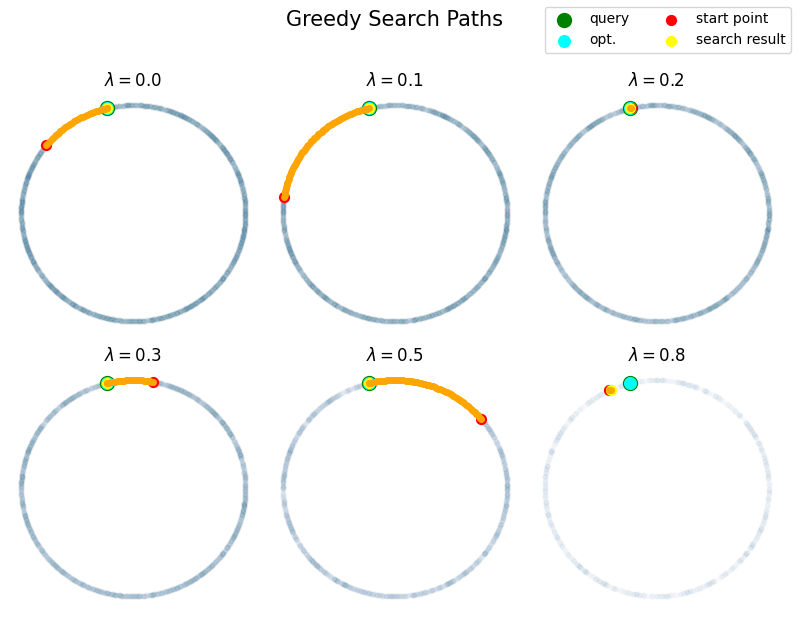

In [130]:
n, d, M = 5000, 1, 1.4
lmbs = [0.0, 0.1, 0.2, 0.3, 0.5, 0.8]
pts = getPts(n, d)
run_walk_plot(pts, n, d, lmbs, M)

Opt. : 7646 find : 7646 #steps : 29 #neighbors(avg) : 11 approx : 1.0
Opt. : 6939 find : 78 #steps : 20 #neighbors(avg) : 8 approx : 13.70401248999844
Opt. : 6122 find : 745 #steps : 9 #neighbors(avg) : 8 approx : 1.1440449485209596
Opt. : 5355 find : 2233 #steps : 6 #neighbors(avg) : 7 approx : 30.693575608555335
Opt. : 3804 find : 1614 #steps : 4 #neighbors(avg) : 4 approx : 30.693575608555335
Opt. : 823 find : 16 #steps : 0 #neighbors(avg) : 1 approx : 26.54318713431106


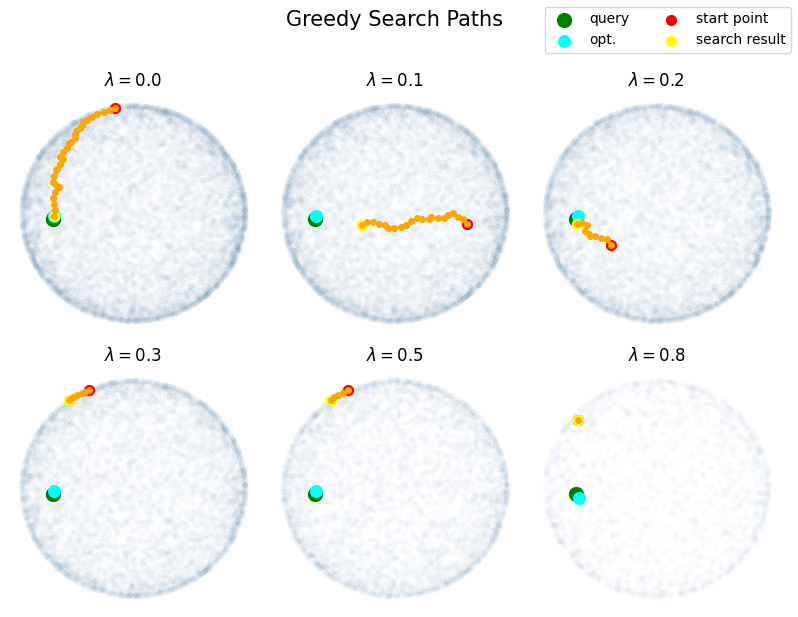

In [146]:
n, d, M = 10000, 2, 1.4
lmbs = [0.0, 0.1, 0.2, 0.3, 0.5, 0.8]
pts = getPts(n, d)
run_walk_plot(pts, n, d, lmbs, M)

Opt. : 7123 find : 7123 #steps : 3 #neighbors(avg) : 59 approx : 1.0
Opt. : 6425 find : 6425 #steps : 3 #neighbors(avg) : 55 approx : 1.0
Opt. : 5653 find : 7709 #steps : 2 #neighbors(avg) : 45 approx : 1.0811376355403333
Opt. : 2587 find : 6761 #steps : 3 #neighbors(avg) : 42 approx : 1.009729143847616
Opt. : 3607 find : 3810 #steps : 3 #neighbors(avg) : 26 approx : 1.1366180272993347
Opt. : 1373 find : 666 #steps : 0 #neighbors(avg) : 12 approx : 1.1345498897786053


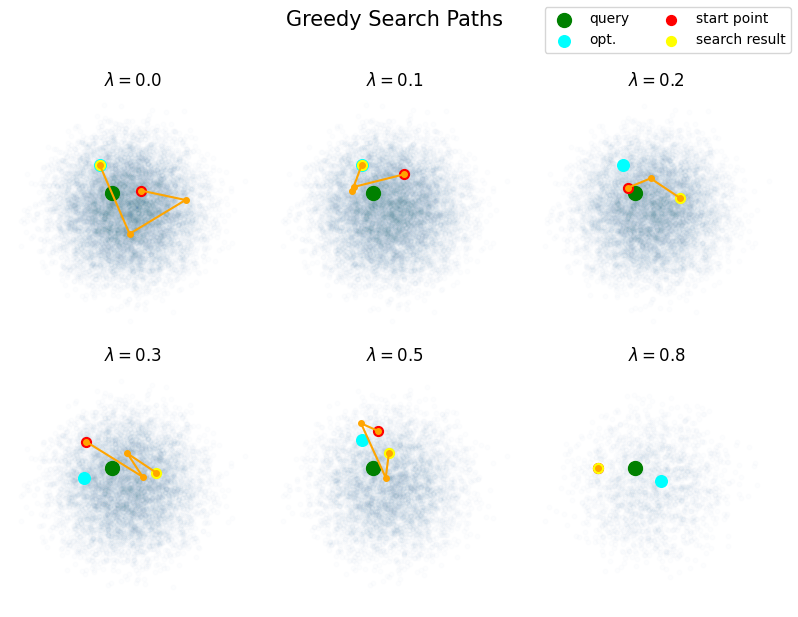

In [173]:
n, d, M = 10000, 16, 1.4
lmbs = [0.0, 0.1, 0.2, 0.3, 0.5, 0.8]
pts = getPts(n, d)
run_walk_plot(pts, n, d, lmbs, M)